In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import decode_predictions
from keras.layers.normalization import BatchNormalization

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time

import pandas

import pickle as pk

from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np

seed = 7

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib


In [3]:
np.random.seed(seed)

In [4]:
data_dir = '/data/oxford102/train'
train_data_dir = "/data/oxford102/train/"
validation_data_dir = "/data/oxford102/train/"
img_width, img_height = 224, 224
batch_size = 128
epochs = 100


In [ ]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(lr=0.0001, momentum=0.9),
         'optimizer_params': None, 
         'batch_size': batch_size,
         'epochs': 100,
         'image_size': (img_width, img_height),
         'log_time': None}

In [5]:
def get_image_generator(input_processor, img_aug=False):
    if not img_aug:
        train_val_datagen = ImageDataGenerator(preprocessing_function=input_processor, 
                                           validation_split=0.2)
    else: 
        train_val_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=input_processor,
            validation_split=0.2)
        
    return train_val_datagen

In [6]:
def get_generators(batch_size, image_size, input_processor, img_aug=False):

    img_width, img_height = image_size
    
    train_val_datagen = get_image_generator(input_processor, img_aug)

    train_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            batch_size=batch_size,
            subset="training",
            class_mode='categorical')

    validation_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            subset="validation",
            batch_size=batch_size,
            class_mode='categorical')
    
    return train_generator, validation_generator


In [8]:
def train_model(params, _model, generators):
    model_name = params["network_name"]
    num_train_img = 4604
    num_val_img = 1094

    np.random.seed(seed)
    log_time = time()
    params['log_time'] = log_time
    batch_size = params.get("batch_size")

    train_generator, validation_generator = generators
    _model.compile(loss = "categorical_crossentropy", optimizer = params["optimizer"], metrics=["accuracy"])


    base = '/data/oxford102/experiments'
    path = os.path.join(base, str(log_time))
    checkpoint = ModelCheckpoint(os.path.join(path, "{}_{}.h5".format(model_name, log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
    tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
    csv_logger = CSVLogger(os.path.join(path, "{}_{}.csv".format(model_name, log_time)), append=True, separator=';')

    try:
        if not os.path.exists(path):
            os.makedirs(path)
        history_callback = _model.fit_generator(
                train_generator,
                steps_per_epoch=train_generator.n // params["batch_size"] // 2,  # use only half the data
                epochs=params["epochs"],
                validation_data=validation_generator,
                validation_steps=validation_generator.n // params["batch_size"],
                callbacks = [checkpoint, early, tensorboard, csv_logger])
    except Exception as e:
        raise(e)
    finally:
        params.pop("optimizer")
        pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
        _model.save_weights(os.path.join(path, 'model_{}_weights_final_{}.h5'.format(model_name, log_time)))  # always save your weights after training or during training
        print(params)
        params
    return history_callback

In [9]:
from keras.models import load_model
model = load_model('oxford102/experiments/1549231745.266355/densenet201_1549231745.266355.h5')

In [10]:
model

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

## thaw the 5th convolutional block

In [14]:
for i, layer in enumerate(model.layers):
    
    if i > 480:
        layer.trainable = True
        print(i, layer.name)
    else:
        layer.trainable = False

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
data_dir = "1549231745.266355"

In [15]:
optimizer=optimizers.SGD(lr=0.0001, momentum=0.9)

In [16]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
input_processor = applications.densenet.preprocess_input

In [22]:
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)

Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


In [25]:
history = train_model(params, model, (train_generator, validation_generator))

Epoch 1/100
17/17 [==============================] - 70s 4s/step - loss: 0.3467 - acc: 0.9540 - val_loss: 0.2696 - val_acc: 0.9248

Epoch 00001: val_acc improved from -inf to 0.92480, saving model to /data/oxford102/experiments/1549339395.8436813/densenet201_1549339395.8436813.h5
Epoch 2/100
17/17 [==============================] - 47s 3s/step - loss: 0.3930 - acc: 0.9467 - val_loss: 0.2559 - val_acc: 0.9265

Epoch 00002: val_acc improved from 0.92480 to 0.92650, saving model to /data/oxford102/experiments/1549339395.8436813/densenet201_1549339395.8436813.h5
Epoch 3/100
17/17 [==============================] - 52s 3s/step - loss: 0.3442 - acc: 0.9576 - val_loss: 0.2762 - val_acc: 0.9213

Epoch 00003: val_acc did not improve from 0.92650
Epoch 4/100
17/17 [==============================] - 43s 3s/step - loss: 0.3518 - acc: 0.9559 - val_loss: 0.2698 - val_acc: 0.9224

Epoch 00004: val_acc did not improve from 0.92650
Epoch 5/100
17/17 [==============================] - 43s 3s/step - loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


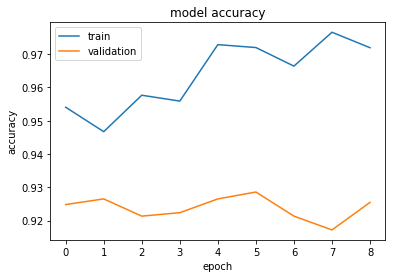

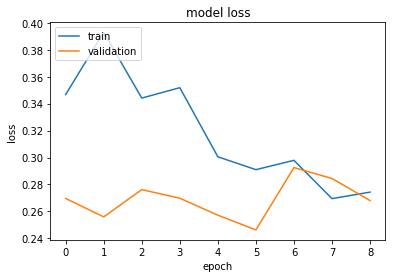

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()